## Protein-Protein Binding Affinity Prediction using Random Forest Regressor

##### Beryl Ramadhian Aribowo 
##### DDP - Master, Kanazawa University

https://github.com/berylgithub

### Feature Extraction

The data is pre-processed to acquire the $D=\{(y^{(n)}, \vec{x}^{(n)})\}^N_{n=1}$ array. By calculating the Heaviside step function that counts the contacts of atoms between proteins ($d_{cutoff}$) within 12 Angstrom. The formula to count the number of occurence between $j$ and $i$ atom is as follows:
<br>
$x_{Z(P_X(j)),Z(P_Y(i))}\equiv\sum^{K_j}_{k=1}\sum^{L_i}_{l=1} \odot (d_{cutoff} - d_{kl})$
<br>

Here $P_X(j)$ corresponds to the protein atoms within the first chain of the protein pairing combination, and $P_Y(i)$ corresponds to the protein atoms within the second one, where four atom types are considered respectively as follows:
<br>
$\{P_N(j)\}_{j=1}^{4} = \{C,N,O,S\}$, $N \in Z^+$,<br>
The hydrophobic patches and acid patches interactions respectively are also considered: 
<br>
- hydrophobic patch : $\{C\alpha_H\}$
<br>
- acid patch : $\{C\alpha_A\}$,
<br>

where $C\alpha_H$ and $C\alpha_A$ is the total interactions between carbon-alpha on Hydrophobic and Acid patch respectively.

Therefore the total atomic interaction features used are $|\{P_N(j)\}_{j=1}^{4}|^2 + |\{C\alpha_H\}| + |\{C\alpha_A\}| = 18$

Suppose there are four chains of protein $S = \{P_1, P_2, P_3, P_4 \}$, the interaction is the combinations of two chains, hence the total of interactions between two chains for this case is $c^{|S|}_2$=6 (where $c$ here refers to combination formula), the list of chains combination are as follows:
<br>
$\sum interaction = interaction(P_1, P_2) + interaction(P_1,P_3) + interaction(P_1,P_4) + interaction(P_2,P_3) + interaction(P_2,P_4) + interaction(P_3,P_4)$

The script used for data preprocessing and feature extraction is available at https://github.com/berylgithub/ppbap.

### Data and Model loading

In [9]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr
from math import sqrt

import pickle
import os

### First type model: 16 features ([C, N, O, S] interactions)

In [2]:
'''Dataset Loader'''
def dataset_loader(filepath):
    data = []
    try:
        with open(filepath, 'rb') as fr:
            try:
                while True:
                    data.append(pickle.load(fr))
            except EOFError:
                pass            
    except FileNotFoundError:
        print('File is not found')
    saved_ids = [d['id'] for d in data]
    return data

standard_data_file = os.getcwd()+'/Data/dataset_alpha_12A.pkl'
combined_ha_data_file = os.getcwd()+'/Data/dataset_ha_beta_12A.pkl'
dataset = dataset_loader(standard_data_file)

features = np.array([data['x_vector'] for data in dataset])
labels = np.array([data['y'] for data in dataset])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=13)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1812, 16)
Training Labels Shape: (1812,)
Testing Features Shape: (604, 16)
Testing Labels Shape: (604,)


In [3]:
'''Model Loader'''
standard_model_file= os.getcwd()+"/Model/rf_pp_alpha_12A_split.pkl"
combined_ha_model_file= os.getcwd()+"/Model/rf_pp_ha_beta_12A_split.pkl"
with open(standard_model_file, "rb") as f:
    rf = pickle.load(f)

C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.22.1. This might lead to 

In [4]:
'''Model evaluation on training set'''
#Mean Absolute Error
preds = rf.predict(x_train)
errors = abs(preds - y_train)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_train)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_train, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_train, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Mean Absolute Error: 0.52
Accuracy: 91.89 %.
Root Mean Squared Error : 0.66
Pearson Correlation Coefficient : 0.98


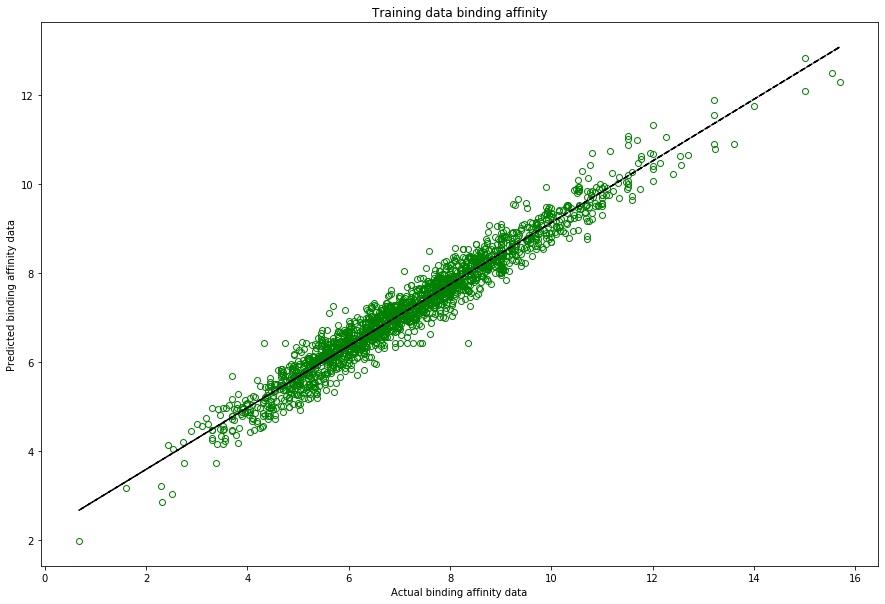

In [6]:
'''Visualization on training set'''
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_train, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
coef = np.polyfit(y_train,preds,1)
poly1d_fn = np.poly1d(coef)
plt.plot(y_train, poly1d_fn(y_train), '--k')

plt.title("Training data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
#plt.legend()
plt.show()

In [7]:
'''Model evaluation on Test set'''
#Mean Absolute Error
preds = rf.predict(x_test)
errors = abs(preds - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_test, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Mean Absolute Error: 1.47
Accuracy: 76.67 %.
Root Mean Squared Error : 1.87
Pearson Correlation Coefficient : 0.35


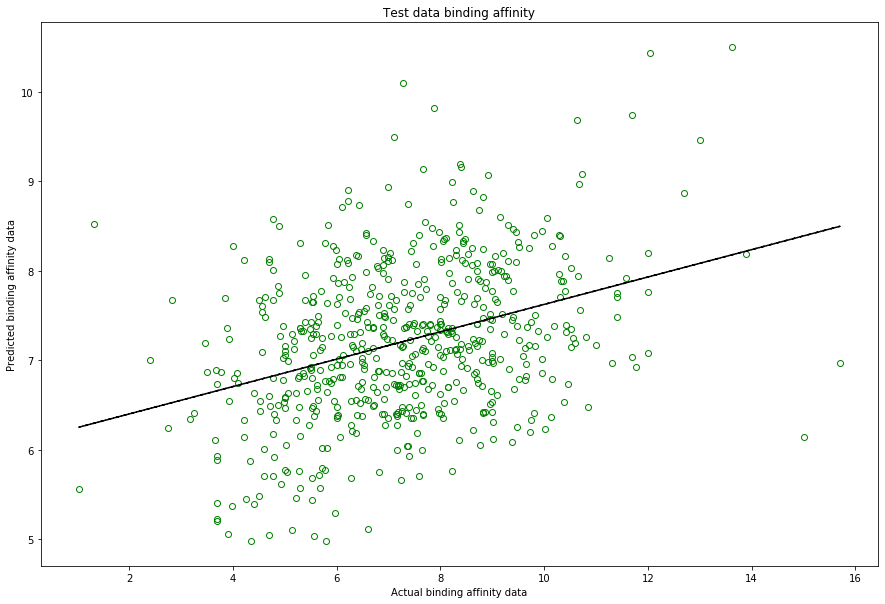

In [8]:
'''Visualization on test set'''
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_test, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
coef = np.polyfit(y_test,preds,1)
poly1d_fn = np.poly1d(coef)
plt.plot(y_test, poly1d_fn(y_test), '--k')


plt.title("Test data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
#plt.legend()
plt.show()


Top Feature ranking:
1. feature 10 (0.083682)
2. feature 13 (0.077048)
3. feature 0 (0.073376)
4. feature 8 (0.069573)
5. feature 12 (0.066819)
6. feature 9 (0.063811)
7. feature 7 (0.063336)
8. feature 3 (0.063243)
9. feature 2 (0.060709)
10. feature 14 (0.059633)
11. feature 6 (0.058835)
12. feature 4 (0.058746)
13. feature 5 (0.054110)
14. feature 11 (0.050171)
15. feature 1 (0.049238)
16. feature 15 (0.047671)


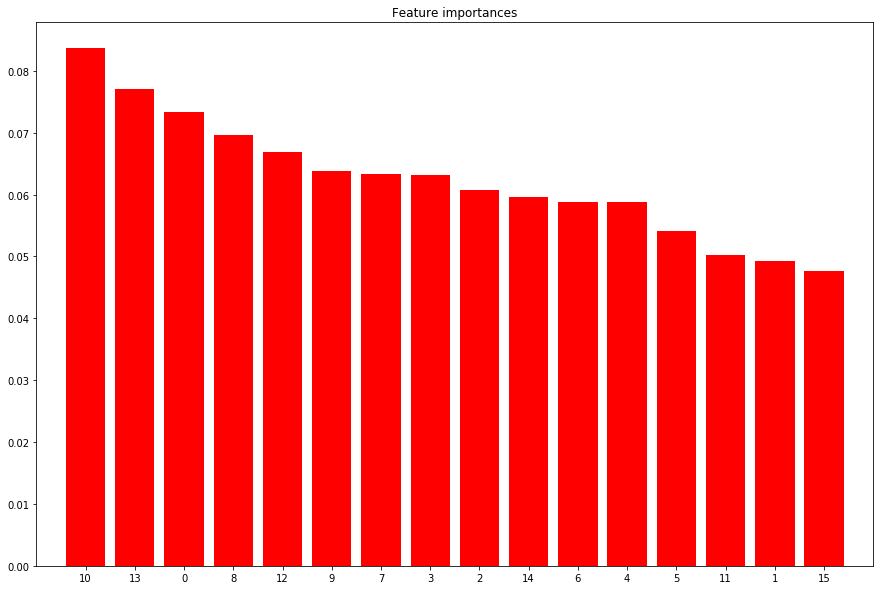

In [13]:
'''
Top 20 features based on combination of:
atom_types = ['C','N','O,'S']
'''

importance = rf.feature_importances_

#indices = np.argsort(importance)[::-1][:20]
indices = np.argsort(importance)[::-1]

print("Top Feature ranking:")
n = importance.shape[0]
#n = 20
for f in range(n):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(n), importance[indices],
       color="r", align="center")
plt.xticks(range(n), indices)
plt.xlim([-1, n])
plt.show()

In [16]:
'''
permutation importance on train data
'''
result = permutation_importance(rf, x_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()
print(importance)
print(result)
print(sorted_idx)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[0.07337565 0.0492378  0.06070876 0.06324309 0.05874584 0.05410997
 0.05883527 0.06333577 0.06957308 0.06381112 0.08368177 0.05017109
 0.06681877 0.07704779 0.05963298 0.04767124]
{'importances_mean': array([0.177196  , 0.07633217, 0.1437247 , 0.14160894, 0.11939359,
       0.09745755, 0.11119658, 0.21882789, 0.162793  , 0.13234326,
       0.24534185, 0.0835425 , 0.13751559, 0.36592612, 0.12178895,
       0.17602715]), 'importances_std': array([0.00472008, 0.00168703, 0.00313548, 0.00448613, 0.00166751,
       0.00254801, 0.0018594 , 0.00778555, 0.00271827, 0.00251567,
       0.00598899, 0.00161946, 0.0031855 , 0.00543508, 0.00274158,
       0.0059742 ]), 'importances': array([[0.18418208, 0.1696747 , 0.17091148, 0.1792321 , 0.17578435,
        0.18341269, 0.1789844 , 0.17912562, 0.17842647, 0.17222612],
       [0.07730113, 0.07387507, 0.0749527 , 0.07727552, 0.07774795,
        0.07670353, 0.07522057, 0.07822649, 0.07840905, 0.07360969],
       [0.14797258, 0.14474106, 0.140148  , 0.1

In [17]:
'''
permutation importance on test data
'''
result = permutation_importance(rf, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()
print(importance)
print(result)
print(sorted_idx)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[0.07337565 0.0492378  0.06070876 0.06324309 0.05874584 0.05410997
 0.05883527 0.06333577 0.06957308 0.06381112 0.08368177 0.05017109
 0.06681877 0.07704779 0.05963298 0.04767124]
{'importances_mean': array([ 0.02792791,  0.00629706,  0.01001   ,  0.01219087, -0.00475826,
       -0.00480654,  0.00537015,  0.02179903,  0.0247389 ,  0.01759114,
        0.04163343, -0.00385844,  0.00853628,  0.07242679, -0.00254297,
        0.06047654]), 'importances_std': array([0.00635217, 0.00510388, 0.00744606, 0.00689883, 0.00742795,
       0.00570663, 0.00743883, 0.01158927, 0.00816707, 0.00587302,
       0.00992401, 0.00426895, 0.00411778, 0.01774861, 0.00595536,
       0.00915155]), 'importances': array([[ 0.02790556,  0.03209645,  0.02194832,  0.04143607,  0.02298808,
         0.03570329,  0.02623041,  0.02112752,  0.02210765,  0.02773577],
       [ 0.00768558,  0.00418145, -0.00060069,  0.00475732,  0.00288586,
         0.01127719,  0.01179469, -0.00240425,  0.01038235,  0.01301109],
       [ 0.

### Second type model: 18 features ([C, N, O, S] + CA_H + CA_A)

#### 12 Angstrom cutoff

In [18]:
data_file = os.getcwd()+'/Data/dataset_ha_beta_12A.pkl'
dataset = dataset_loader(data_file)

features = np.array([data['x_vector'] for data in dataset])
labels = np.array([data['y'] for data in dataset])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=13)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1812, 18)
Training Labels Shape: (1812,)
Testing Features Shape: (604, 18)
Testing Labels Shape: (604,)


In [19]:
'''Model Loader'''
model_file= os.getcwd()+"/Model/rf_pp_ha_beta_12A_split.pkl"
with open(model_file, "rb") as f:
    rf = pickle.load(f)

C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [20]:
'''Model evaluation on Test set'''
#Mean Absolute Error
preds = rf.predict(x_test)
errors = abs(preds - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_test, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Mean Absolute Error: 1.41
Accuracy: 77.63 %.
Root Mean Squared Error : 1.8
Pearson Correlation Coefficient : 0.43


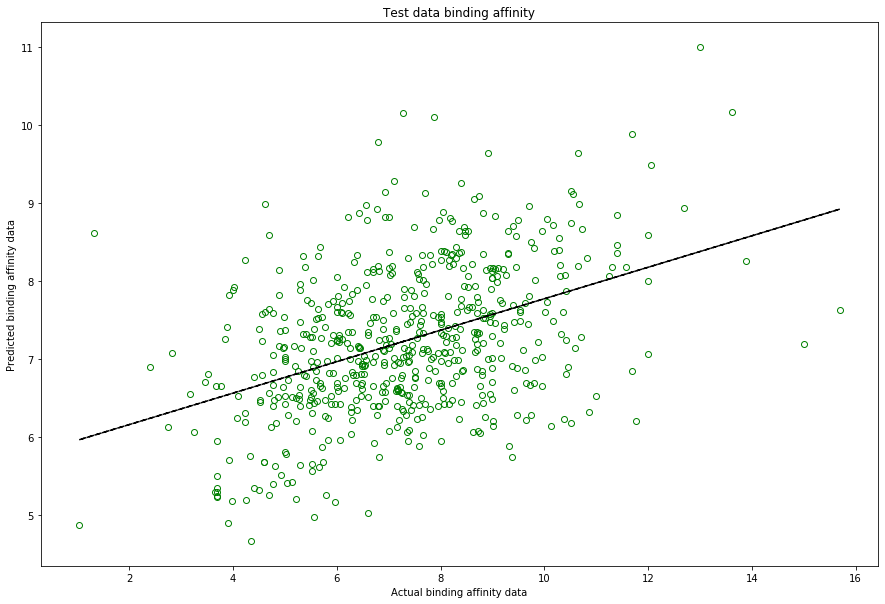

In [21]:
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_test, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
coef = np.polyfit(y_test,preds,1)
poly1d_fn = np.poly1d(coef)
plt.plot(y_test, poly1d_fn(y_test), '--k')

plt.title("Test data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
#plt.legend()
plt.show()

Top Feature ranking:
1. feature 17 (0.108756)
2. feature 16 (0.101709)
3. feature 10 (0.075521)
4. feature 8 (0.060101)
5. feature 9 (0.059726)
6. feature 0 (0.056625)
7. feature 13 (0.053568)
8. feature 6 (0.049845)
9. feature 4 (0.049822)
10. feature 2 (0.049602)
11. feature 12 (0.047659)
12. feature 5 (0.043194)
13. feature 1 (0.043105)
14. feature 7 (0.043006)
15. feature 14 (0.042519)
16. feature 3 (0.041040)
17. feature 11 (0.040243)
18. feature 15 (0.033961)


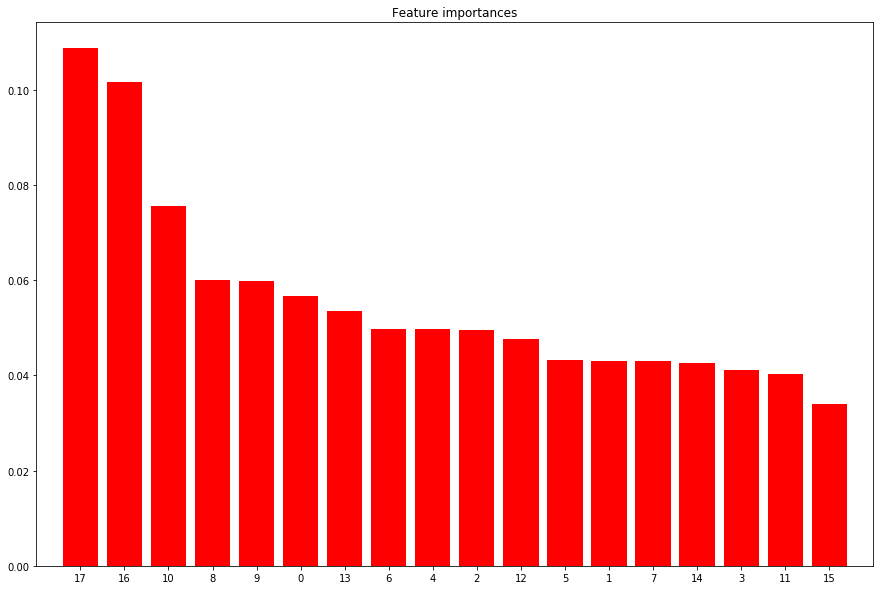

In [22]:
'''
Top features based on combination of:
atom_types = ['C','N','O,'S']
'''

importance = rf.feature_importances_

#indices = np.argsort(importance)[::-1][:20]
indices = np.argsort(importance)[::-1]

print("Top Feature ranking:")
n = importance.shape[0]
#n = 20
for f in range(n):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))


plt.figure()
plt.title("Feature importances")
plt.bar(range(n), importance[indices],
       color="r", align="center")
plt.xticks(range(n), indices)
plt.xlim([-1, n])
plt.show()

In [23]:
'''
permutation importance on train data
'''
result = permutation_importance(rf, x_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()
print(importance)
print(result)
print(sorted_idx)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[0.05662473 0.04310486 0.04960245 0.04103954 0.04982183 0.04319387
 0.0498449  0.04300576 0.06010076 0.05972551 0.07552061 0.04024279
 0.04765858 0.05356842 0.04251898 0.03396121 0.10170944 0.10875577]
{'importances_mean': array([0.11673993, 0.06239268, 0.10561461, 0.06061745, 0.10864211,
       0.06283129, 0.0975277 , 0.08867516, 0.13241765, 0.1496225 ,
       0.20302726, 0.05719417, 0.07636657, 0.18162455, 0.06540092,
       0.08135953, 0.26463167, 0.56598616]), 'importances_std': array([0.0022112 , 0.00108232, 0.00244206, 0.00191047, 0.00433862,
       0.00091958, 0.00187709, 0.00336598, 0.00318898, 0.00356667,
       0.00435304, 0.0011764 , 0.00201012, 0.00319611, 0.0018678 ,
       0.00215856, 0.00807694, 0.01167579]), 'importances': array([[0.1165157 , 0.11595177, 0.1138381 , 0.12207059, 0.11556272,
        0.11506764, 0.11645053, 0.11767968, 0.11885328, 0.11540929],
       [0.060601  , 0.06141855, 0.06142175, 0.06379503, 0.06205628,
        0.0628047 , 0.06236902, 0.06255423, 0.

In [24]:
'''
permutation importance on test data
'''
result = permutation_importance(rf, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()
print(importance)
print(result)
print(sorted_idx)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[0.05662473 0.04310486 0.04960245 0.04103954 0.04982183 0.04319387
 0.0498449  0.04300576 0.06010076 0.05972551 0.07552061 0.04024279
 0.04765858 0.05356842 0.04251898 0.03396121 0.10170944 0.10875577]
{'importances_mean': array([ 0.02725345,  0.01000416,  0.00760272,  0.0068398 ,  0.02740422,
        0.00322749,  0.00595238,  0.00261261,  0.02004775,  0.03816556,
        0.03529331,  0.00086465,  0.00655367,  0.04478114, -0.00309697,
        0.03492419,  0.05808484,  0.19752509]), 'importances_std': array([0.00804754, 0.00289077, 0.00750033, 0.00312711, 0.01141916,
       0.00209769, 0.00905016, 0.00620755, 0.00817539, 0.01032546,
       0.00986885, 0.00443872, 0.00316989, 0.01390302, 0.00319794,
       0.00618847, 0.00943972, 0.01642885]), 'importances': array([[ 4.70887250e-02,  3.22756479e-02,  2.30986465e-02,
         2.84932071e-02,  2.76115934e-02,  2.84044550e-02,
         2.40102925e-02,  2.67795142e-02,  1.61120586e-02,
         1.86603224e-02],
       [ 1.75504350e-02,  8.80

#### 4 Angstrom cutoff

#### 8 Angstrom cutoff

##### 16 Angstrom cutoff

### Cross Fold Validation

In [29]:
'''K-Fold model evaluation'''
folds = [3,4,5,7,10]
kfolds=[]
for fold in folds:
    #with open(os.getcwd()+"/Model/rf_pp_a_"+str(fold)+"fold_best.pkl", "rb") as f:
    with open(os.getcwd()+"/Model/cfold/rf_pp_ha_a_"+str(fold)+"fold_best.pkl", "rb") as f:
        kfolds.append(pickle.load(f))

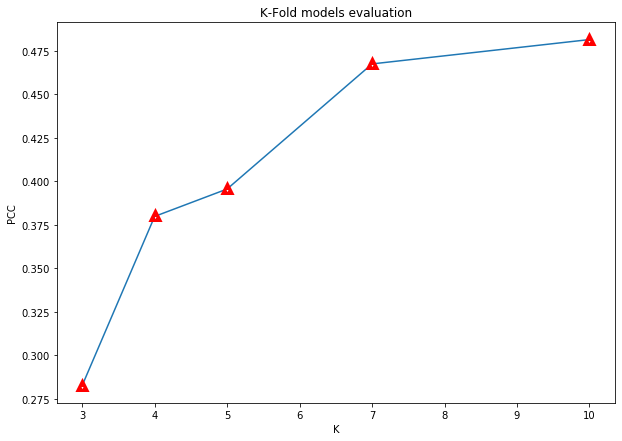

In [30]:
ks = np.array([kfold["k"] for kfold in kfolds])
pcc_tests = np.array([kfold["pcc_test"] for kfold in kfolds])
pcc_trains = np.array([kfold["pcc_train"] for kfold in kfolds])

fig_size = np.zeros(2)
fig_size[0] = 10
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(ks, pcc_tests, '^-', markerfacecolor="None", markeredgecolor='red', markeredgewidth=5)
plt.title("K-Fold models evaluation")
plt.xlabel('K')
plt.ylabel('PCC')
#plt.legend()
plt.show()

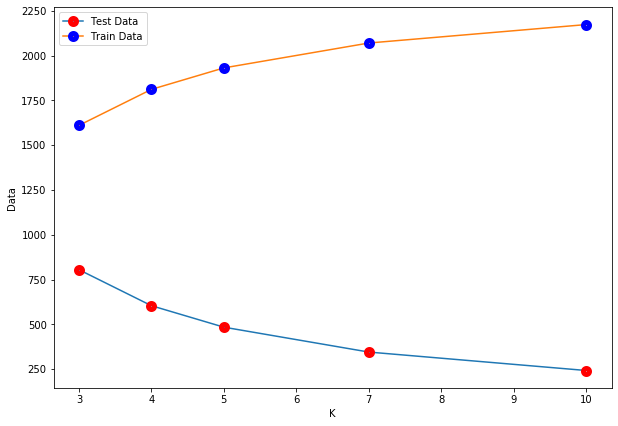

In [31]:
total_train_data = np.array([kfold["train_idx"].shape[0] for kfold in kfolds])
total_test_data = np.array([kfold["test_idx"].shape[0] for kfold in kfolds])
plt.plot(ks, total_test_data,'o-', markerfacecolor="None", markeredgecolor='red', markeredgewidth=5, label="Test Data")
plt.plot(ks, total_train_data,'o-', markerfacecolor="None", markeredgecolor='blue', markeredgewidth=5, label="Train Data")
plt.xlabel("K")
plt.ylabel("Data")
plt.legend()
plt.show()

### Inference on various complexes

In [33]:
'''Full-data model load'''
def data_load(filename):
    '''
    data checker
    '''
    data = []
    try:
        with open(filename, 'rb') as fr:
            try:
                while True:
                    data.append(pickle.load(fr))
            except EOFError:
                pass            
    except FileNotFoundError:
        print('File is not found')
    return data

full_model = os.getcwd()+"/Model/rf_pp_ha_alpha_full.pkl"
with open(full_model, "rb") as f:
    rf = pickle.load(f)

### Inference on PC-PC

In [34]:
path = os.getcwd()+"/Data/data_PC-PC.pkl"
data =data_load(path)
ids = [d["id"] for d in data]
vectors = [d["x_vector"] for d in data]
temp = ids[1]
del ids[1]
ids.append(temp)
temp = vectors[1]
del vectors[1]
vectors.append(temp)
pred_PCPC = rf.predict(vectors)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


### Inference on PC-CytF

In [35]:
path = os.getcwd()+"/Data/data_PC-CF.pkl"
data =data_load(path)
ids = [d["id"] for d in data]
vectors = [d["x_vector"] for d in data]
temp = ids[1]
del ids[1]
ids.append(temp)
temp = vectors[1]
del vectors[1]
vectors.append(temp)
pred_PCCF = rf.predict(vectors)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


### Inference on PC-CytF experimental structure

In [36]:
path = os.getcwd()+"/Data/data_PC-CF_exp.pkl"
data =data_load(path)
ids = [d["id"] for d in data]
vectors = [d["x_vector"] for d in data]
pred_PCCF_exp = rf.predict(vectors)
print(pred_PCCF_exp)
print(ids)

[6.82370286 7.34691624 7.50137857]
['1tkw.pdb', '2jxm.pdb', '2pcf.pdb']


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


### Inference on 4azu

In [37]:
path = os.getcwd()+"/Data/data_4azu.pkl"
data =data_load(path)
vectors = [d["x_vector"] for d in data]
pred_4azu = rf.predict(vectors)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


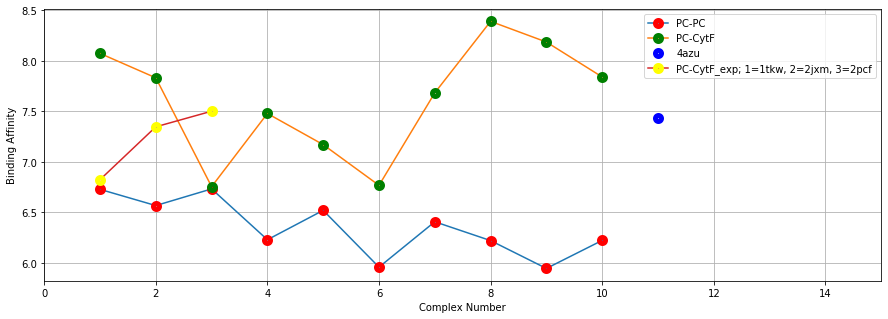

In [39]:
import matplotlib.pyplot as plt
length = 10
idx = np.linspace(1, length, length)
fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.xlim([0,15])
plt.plot(idx, pred_PCPC,'o-', markerfacecolor="None", markeredgecolor='red', markeredgewidth=5, label="PC-PC" )
plt.plot(idx, pred_PCCF,'o-', markerfacecolor="None", markeredgecolor='green', markeredgewidth=5, label="PC-CytF")
plt.plot(11, pred_4azu,'o', markerfacecolor="None", markeredgecolor='blue', markeredgewidth=5, label="4azu")
plt.plot(np.linspace(1, 3, 3), pred_PCCF_exp,'o-', markerfacecolor="None", markeredgecolor='yellow', markeredgewidth=5, label="PC-CytF_exp; 1=1tkw, 2=2jxm, 3=2pcf")
plt.xlabel("Complex Number")
plt.ylabel("Binding Affinity")
plt.legend()
plt.grid(True)
plt.show()